In [1]:
%matplotlib inline
%config IPCompleter.greedy=True

# What versions
import sys

import pandas as pd
import sklearn as sk
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

import os
import matplotlib.pyplot as plt
import datetime as dt
import collections
import numpy as np

Init Plugin
Init Graph Optimizer
Init Kernel


<font size="9">P&nbsp;R&nbsp;E&nbsp;P&nbsp;A&nbsp;R&nbsp;I&nbsp;N&nbsp;G&ensp; D&nbsp;A&nbsp;T&nbsp;A</font>

In [2]:
#--------------------------- preparing path for source files ---------------------------

data_path = "/Users/realmartt/4 F O U R/Final Sem/Final Year Project/pythonProject/s_a"
file_name = "600070.SH.CSV"

In [3]:
#--------------------------- load data, trim data & view data ---------------------------

#load the file into pandas dataframe
def load_data(data_path=data_path, file_name=file_name):
    path = os.path.join(data_path, file_name)
    return pd.read_csv(path, encoding = 'gb2312')
  

#drop useless data and set 'Date' as index
def altering(df):
    
    #convert the headers to English
    dict = {'代码': 'Code',
            '简称': 'Name',
            '日期': 'Date',
            '前收盘价(元)': 'Forward_Close',
            '开盘价(元)': 'Open',
            '最高价(元)': 'High',
            '最低价(元)': 'Low',
            '收盘价(元)': 'Close',
            '成交量(股)': 'Volume',
            '成交金额(元)': 'Volume In Price',
            '涨跌(元)': 'Change In Price',
            '涨跌幅(%)': 'Change',
            '均价(元)': 'Avg Price',
            '换手率(%)': 'Turnover Rate',
            'A股流通市值(元)': 'Value A',
            'B股流通市值(元)': 'Value B',
            '总市值(元)': 'Tol Value',
            'A股流通股本(股)': 'Shares A',
            'B股流通股本(股)': 'Shares B',
            '总股本(股)': 'Tol Shares',
            '市盈率': 'P/E Ratio',
            '市净率': 'P/B Ratio',
            '市销率': 'P/S Ratio',
            '市现率': 'P/CF Ratio'}
    df.rename(columns=dict,
              inplace=True)
    
    #drop the N/A & 0 columns
    df = df.drop(columns=['Value B', 'Shares B', 'Unnamed: 24'])
    df['Date'] = pd.to_datetime(df['Date'])
    #make Date the index
    df = df.set_index('Date')
    #Drop the occasional N/A s
    df = df.dropna(subset=['Volume', 'Volume In Price', 'Avg Price', 'Turnover Rate'])
    
    #print the name/code of the stock
    print("What it is: ")
    print(df['Code'][0], df['Name'][0])
    print("\n")
    
    #we do not need them anymore
    df = df.drop(columns=['Code', 'Name']) 
    return df
    
    
#view the data
def viewing(df, view_header=False, view_info=False, view_stat=False, view_hist=False, view_corr=False):
    if view_header:
        print(df.head())
        print("\n")
    if view_info:
        print(df.info())
        print("\n")
    if view_stat:
        print(df.describe())
        print("\n")
    if view_hist:
        df.hist(bins=50, figsize=(20,15))
        plt.show()
        print("\n")
    if view_corr:
        corr_matrix = df.corr()
        print(corr_matrix['Close'].sort_values(ascending=False))

In [4]:
#----------------------------- call the functions -----------------------------

df = load_data()
df = altering(df)
viewing(df,1,0,0,0,0) #header, info, stat, hist ¶ corr
df.shape

What it is: 
600070.SH 浙江富润


            Forward_Close    Open    High     Low   Close      Volume  \
Date                                                                    
1997-06-04            NaN  1.9282  2.0689  1.9073  1.9438  15566900.0   
1997-06-05         1.9438  1.7718  1.8344  1.7499  1.7499   1370700.0   
1997-06-06         1.7499  1.5748  1.5748  1.5748  1.5748    306400.0   
1997-06-09         1.5748  1.4175  1.5217  1.4175  1.4717   3727200.0   
1997-06-10         1.4717  1.4592  1.4633  1.3247  1.3247   1897800.0   

            Volume In Price  Change In Price   Change  Avg Price  \
Date                                                               
1997-06-04      297031218.0              NaN      NaN    19.0809   
1997-06-05       23127388.0          -0.1939  -9.9732    16.8727   
1997-06-06        4629704.0          -0.1751 -10.0060    15.1100   
1997-06-09       51987055.0          -0.1032  -6.5520    13.9480   
1997-06-10       25170218.0          -0.1470  -9.9

(4452, 19)

In [5]:
#----------------------------- Split & normalize the data -----------------------------
#only care about 'Close' and 'Volume'
df = df[['Close', 'Volume']]
#split the data
column_indices = {name:index for index,name in enumerate(df.columns)}
train_data = df[:int(len(df)*0.8)]
test_data = df[int(len(df)*0.8):]
num_features = df.shape[1]

#normalization
train_data =(train_data-train_data.min())/(train_data.max()-train_data.min())

test_data =(test_data-test_data.min())/(test_data.max()-test_data.min())


In [6]:
train_data.head()

,Close,Volume
Date,,
1997-06-04,0.302471,0.407646
1997-06-05,0.258427,0.035784
1997-06-06,0.218653,0.007905
1997-06-09,0.195234,0.097511
1997-06-10,0.161844,0.049591


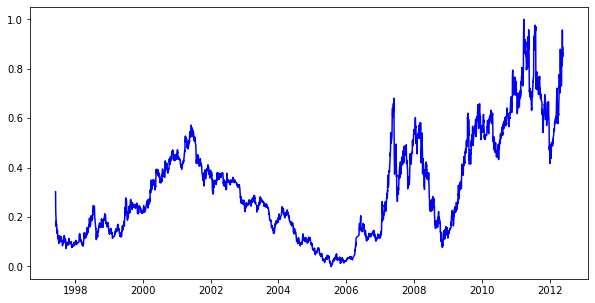

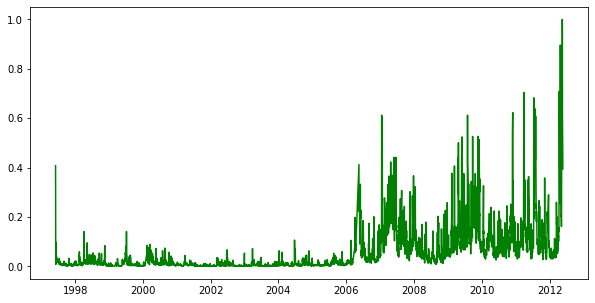

In [7]:
plt.figure(figsize=(10,5))
plt.plot(train_data.loc[:,['Close']], color="blue", label=f"Actual company Price");
plt.figure(figsize=(10,5))
# plt.plot(test_data.loc[:,['Close']], color="green", label=f"Actual company Price");
plt.plot(train_data.loc[:,['Volume']], color="green", label=f"Volume");

In [8]:
train_data.shape
test_data.shape

(3561, 2)

(891, 2)

<font size="9">Transform Data (Through Window)</font>

In [9]:
class CreateWindow:
    def __init__(self, input_width, label_width, shift, label_columns, train_df=train_data, test_df=test_data):
        
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.label_columns = label_columns
        self.train_df = train_df
        self.test_df = test_df
        
        self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])
    
    def split_window(self, features):
        inputs = features[self.input_slice, :]
        labels = features[self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack([labels[:, self.column_indices[name]] for name in self.label_columns], axis=-1)

        return inputs, labels
    
    def get_tol_win_size(self):
        return self.total_window_size

<font size="9">------------------------------------</font>

In [10]:
#----------------------------- hyperparameters -----------------------------
epochs = 5     # how many times the model is going to see the full dataset
gamma = 0.97     # discount rate: how important the immediate rewards are

max_buffer_size = 150    # how big the replay buffer can be
batch_size = 15          # the size of data being used in experience replay

input_width=10
label_width=1
shift=1
jump = 10

<font size="9">Policy & Target Network</font>

In [11]:
# create policy & target network
class Networks:
    def __init__(self):
        self.policy = self.create_policy()
        self.target = self.create_target()
    
    def create_policy(self):
        model = keras.models.Sequential([
            keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None,2]),
            keras.layers.SimpleRNN(20),
            keras.layers.Dense(3)
        ])
        
        model.compile(loss='mse',
                      optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001))
        
        return model
        
    def get_policy(self):
        return self.policy
    
    def policy_feed_data(self, data):
        return self.policy(data)

    def create_target(self):
        return keras.models.clone_model(self.policy)
    
    def get_target(self):
        return self.target
    
    # target network's weights only updated once a certain times
    def update_target_network(self):
        self.target.set_weights(self.policy.get_weights())

    

In [12]:
models = Networks()

Metal device set to: Apple M1


2022-06-12 21:22:14.378720: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-12 21:22:14.379018: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<font size="9">E&nbsp;N&nbsp;V&nbsp;I&nbsp;R&nbsp;O&nbsp;N&nbsp;M&nbsp;E&nbsp;N&nbsp;T</font>

In [13]:
# environment, can output state and reward.
class Environment:
    def __init__(self, option):
        if option == 1:
            self.data = train_data
        elif option == 2:
            self.data = test_data
            
    def get_state(self, timesteps, jump, window):
        raw_data = self.data[timesteps*jump : timesteps*jump + window.get_tol_win_size()]
        diffed_data = np.array(raw_data.diff().fillna(0.0))
        
        return window.split_window(diffed_data), window.split_window(np.array(raw_data))
        
    def get_reward(self, action, state):
        coef = 100
        
        diff_amt = state[1][0]-state[0][-1][0]
        diff_sign = np.sign(diff_amt)
       
        if abs(diff_amt) <= 0.0001:  
            if action == 0:
                reward = 1
            else:
                reward = 0
        else:
            if action != 0:
                reward = diff_sign * action * coef
            else:
                reward = -0.01
          
        return reward
        

<font size="9">A&nbsp;G&nbsp;E&nbsp;N&nbsp;T</font>

In [14]:
# agent, can act
class Agent:
    def __init__(self):
        self.actions = [-1, 0, 1]
        
    def epsilon_greedy_policy(self, state, epsilon, models):
        if np.random.rand() < epsilon:
            return np.random.randint(low=-1, high=2)
        else:
            Q = models.get_policy().predict(np.expand_dims(state,0))
            return self.actions[np.argmax(Q[0])] 

            

<font size="9">Experience Replay</font>

In [15]:
# train the policy network, using experience replay.
class Replay:
    def __init__(self, max_buffer_size):
        self.replay_buffer = collections.deque(maxlen=max_buffer_size)
        
    def get_len(self):
        return len(self.replay_buffer)
        
    def sample_experiences(self, batch_size):
        indices = np.random.randint(len(self.replay_buffer), size = batch_size)
        batch = [self.replay_buffer[index] for index in indices]
        
        state, action, reward, state_next, last_step = [
            np.array([experience[field_index] for experience in batch]) for field_index in range(5)
        ]
        
        return state, action, reward, state_next, last_step
    
    def store_experiences(self, state, action, reward, state_next, last_step):
        self.replay_buffer.append((state, action, reward, state_next, last_step))
        
    def exprience_replay(self, gamma, batch_size, samples, models):
        rSell = []
        rHold = []
        rBuy = []
        
        action_space = [-1, 0, 1]
        state_, action_, reward_, state_next_, last_step_ = samples
        for i in range(batch_size):
            state, action, reward, state_next, last_step = state_[i], \
                                    action_[i], reward_[i], state_next_[i], last_step_[i]      
            
            if action == -1:
                rSell.append(reward)
            elif action == 0:
                rHold.append(reward)
            if action == 1:
                rBuy.append(reward)
            
            # get target Q according to the Bellman equation
            Q_prime = models.get_target().predict(np.expand_dims(state_next,0))
            opt_Q_prime = np.max(Q_prime, axis=1) 
            targetQ = reward + (1 - last_step) * gamma * opt_Q_prime
            # get Q
            Q = models.get_policy()(np.expand_dims(state,0))
            # modify Q to approximate the target1
            newQ = Q.numpy()
            for index, ele in enumerate(targetQ):
                newQ[index][action_space.index(action)] = ele
            newQ = tf.convert_to_tensor(newQ)
            
            if i == 0:
                X = np.asarray(state)
                Y = np.asarray(newQ)
                X = np.expand_dims(X, axis=0)
                Y = np.expand_dims(Y, axis=0)
            else:
                state = np.expand_dims(state, axis=0)
                newQ = np.expand_dims(newQ, axis=0)
                X = np.append(X, state, axis=0)
                Y = np.append(Y, newQ, axis=0)
        
#         print(len(rSell), len(rHold), len(rBuy), " Sell: ", np.mean(rSell), " Hold: ", np.mean(rHold), " Buy: ", np.mean(rBuy))
#         print("Q' : ",Q_prime)
#         print("opQ' : ",opt_Q_prime)
#         print("targetQ: ",targetQ)
#         print("Q: ",Q)
#         print("newQ: ",newQ)
        
              
        models.get_policy().fit(X, Y, epochs=1, batch_size=batch_size, verbose=0)
        
            
    def train_models(self, gamma, batch_size, models):
        samples = self.sample_experiences(batch_size)
        self.exprience_replay(gamma, batch_size, samples, models)

<font size="9">Main Loop (Train The Models)</font>


In [16]:
#initalize environment, agent & replay memory
environment = Environment(1)
agent = Agent()

rep_buffer = Replay(max_buffer_size)

window = CreateWindow(input_width=input_width, label_width=label_width,\
                      shift=shift, label_columns=['Close'])

In [19]:
print(environment.get_state(0,10,window)[1])

(array([[0.30247138, 0.40764555],
       [0.25842722, 0.03578421],
       [0.21865346, 0.00790548],
       [0.19523442, 0.09751138],
       [0.16184354, 0.04959129],
       [0.18337725, 0.06732754],
       [0.16870343, 0.03079417],
       [0.1710885 , 0.03414182],
       [0.17131565, 0.03837222],
       [0.15686898, 0.02131179]]), <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.14691986]])>)


In [18]:
# ----------------------------- the main loop -----------------------------

for epo in range(epochs):     # for every time the model is going to see the whole data 
    reward_list = []
    action_list = []
    
    a = []
    b = []
    c = []
    
    last_step = 0
    for timesteps in range((len(train_data) - window.get_tol_win_size())// jump):  
        epsilon = max(1 - timesteps / ((len(train_data) - window.get_tol_win_size())// jump)*0.99, 0.01)
        # get state, action, reward and state_next, and store them to the replay buffer
        state = environment.get_state(timesteps, jump, window)[0][0]
        state_inc_label = environment.get_state(timesteps, jump, window)
        action = agent.epsilon_greedy_policy(state, epsilon, models)
        reward = environment.get_reward(action, state_inc_label[1])
        
        reward_list.append(reward)
        action_list.append(action)
        
        if action == -1:
            a.append(round(float(reward),4))
        elif action == 0:
            b.append(round(float(reward),4))
        elif action == 1:
            c.append(round(float(reward),4))
        
        state_next = environment.get_state(timesteps + 1, jump, window)[0][0]
        # reachs the end of the data, last_step = 1, also stored in the buffer
        if timesteps == (len(train_data) - window.get_tol_win_size())// jump:
            last_step = 1
        # store five parameters
        rep_buffer.store_experiences(state, action, reward, state_next, last_step)
        
        # if the buffer has stored enough experiences, then begin to train the mdoels.    
        if rep_buffer.get_len() >= batch_size*2:
            rep_buffer.train_models(gamma, batch_size, models)
        # update the target network's weights.
        if timesteps % 50 == 0:
            models.update_target_network()
        if timesteps % 100 == 0:
            print("epo: "+str(epo)+", timesteps: "+ str(timesteps))
    
            
    print('Epoch', epo, '---------', 'mean reward: ', np.mean(reward_list))
    print("+++++Detailed Mean+++++++", round(np.mean(a),4), round(np.mean(b),4), round(np.mean(c),4))
    print(action_list)

    reward_list.clear()
    a.clear()
    b.clear()
    c.clear()
    

epo: 0, timesteps: 0


/var/folders/p7/m0xl9lb16f187dq42tn3pw7h0000gn/T/ipykernel_48925/353405378.py:14: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([experience[field_index] for experience in batch]) for field_index in range(5)
2022-05-31 19:59:51.175985: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-05-31 19:59:52.289364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


epo: 0, timesteps: 100
Epoch 0 --------- mean reward:  [4.51081081]
+++++Detailed Mean+++++++ 16.6667 0.0226 -5.2632
[1, -1, 0, 0, 0, 0, -1, 0, 1, -1, 0, -1, 1, 0, -1, -1, -1, 1, 1, -1, 0, -1, 0, 1, 1, 1, 1, 0, 1, -1, 1, -1, 1, 0, -1, -1, 1, 1, 1, 0, 1, -1, 0, -1, 1, -1, -1, 1, 0, -1, 0, -1, 1, 1, -1, 0, -1, -1, 0, 0, -1, -1, 0, 1, 1, -1, 1, -1, 0, -1, -1, -1, 0, -1, 0, 1, 0, 0, 1, -1, -1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, -1, -1, 1, -1, 1, -1, 1, 0, -1, -1, 1, 0, -1, 0, 1, -1, -1, -1]
epo: 1, timesteps: 0
epo: 1, timesteps: 100
Epoch 1 --------- mean reward:  [5.40153153]
+++++Detailed Mean+++++++ 16.6667 -0.01 -3.8462
[-1, -1, -1, 0, 0, -1, 1, -1, 0, 1, 1, -1, -1, -1, 0, 0, 1, 1, 0, -1, 1, -1, -1, 0, -1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, -1, -1, -1, 0, 0, -1, 1, -1, 1, 0, 0, 1, -1, -1, 0, 0, -1, 0, 0, -1, 0, 0, 1, -1, -1, 0, -1, 0, -1, -1, -1, -1, 0, 0, 0, -1, 0, 1, -1, -1, 0, 0, 0, 1, 1, 0, 1, -1, 1, 0, 0, 1, -1, -1, 1, 0, 1, -1, 1, 0, -1, -1, 1, -1, -1, 0, 1, -1, -1

<font size="9">Evaluate The Models</font>


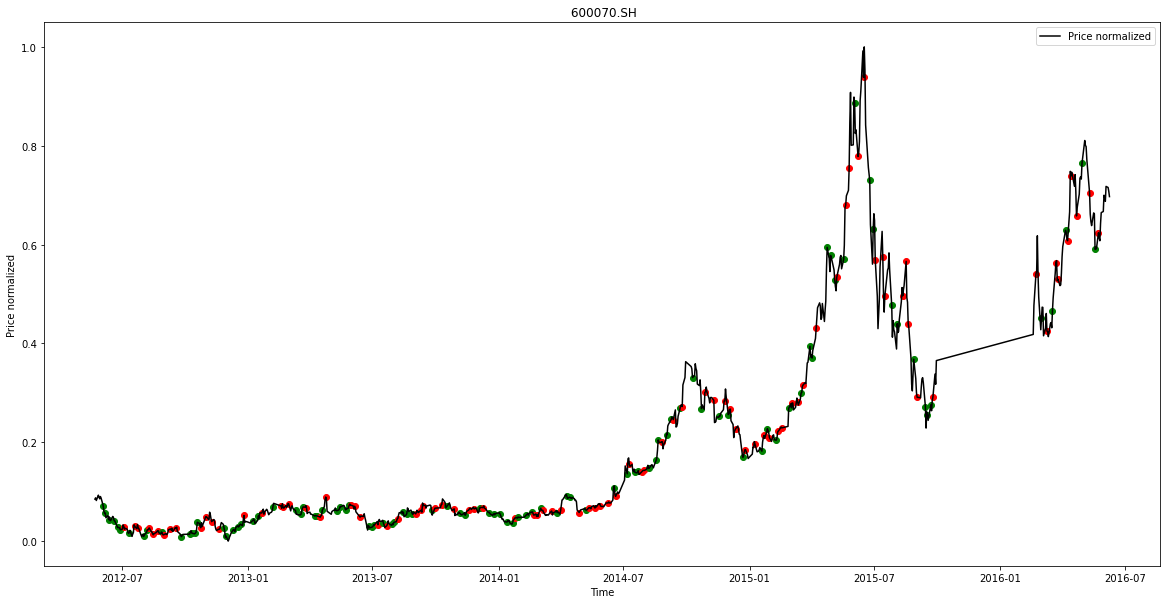

[4.78156997]
[1, 1, 1, 0, 1, 1, 1, -1, 0, 1, 0, -1, -1, 0, 1, 1, -1, -1, 0, -1, 1, -1, 0, -1, 0, -1, 0, 1, 1, 1, 1, 1, -1, 0, -1, 0, -1, 0, -1, 0, 1, 1, 0, 1, 0, 1, 1, -1, 0, 1, 0, 1, -1, 0, 0, 0, 1, -1, -1, 0, -1, 0, 1, 0, 1, 1, -1, 0, 1, 1, -1, 1, -1, 0, 0, 1, 1, 0, 1, 1, -1, -1, -1, 0, 0, 1, 1, 1, -1, 0, 1, -1, 0, 1, 1, -1, 0, 1, 1, 0, 1, -1, 0, -1, -1, 0, 1, -1, -1, 0, 1, 0, -1, 0, 1, 0, 1, -1, 0, -1, 0, 1, -1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, -1, 1, 1, 0, 1, -1, -1, 1, -1, 0, 0, -1, 0, 1, -1, 0, 1, 1, 0, 0, -1, 0, 1, -1, 0, -1, 0, -1, 0, -1, 0, 1, -1, 0, 1, -1, 0, 1, 1, -1, -1, 0, 1, 0, 1, 1, -1, 0, 1, 1, -1, 0, 1, -1, 0, 1, 0, 0, 1, -1, 0, 0, -1, 0, 1, 0, -1, 1, -1, 0, -1, 0, 1, -1, 0, 0, -1, 0, 1, -1, 1, -1, 0, 1, -1, -1, 1, -1, 0, -1, 1, -1, 0, 1, 1, -1, 0, 0, 0, 1, 1, 1, -1, 0, 1, -1, -1, 0, 1, -1, 0, -1, 0, 1, 1, -1, 0, -1, -1, 0, 1, 0, 1, 0, -1, -1, -1, 0, 1, -1, 0, 1, 1, 1, -1, 0, -1, 0, 1, 0, -1, 0, 1, -1, -1, 0, 1, -1, -1, 0, -1, 0, 1, 0, -1, 0, 1, -1, 0, 0]


In [36]:
jump2 = 3
actions = [-1, 0, 1]
environment2 = Environment(2)
window2 = CreateWindow(input_width=10, label_width=1,\
                      shift=1, label_columns=['Close'])
# visualize
plt.figure(figsize=(20,10))
plt.plot(test_data.loc[:,['Close']], color="black", label=f"Price normalized");

action_list = []
reward_list = []
for i in range((len(test_data) - window2.get_tol_win_size())// jump2): 
    state = environment2.get_state(i, jump2, window2)[0][0]
    action = agent.epsilon_greedy_policy(state, 0, models)
    reward_list.append(environment2.get_reward(action, environment2.get_state(i, jump2, window2)[1]))
    action_list.append(action)

for x,action in enumerate(action_list):
    if action == 1:
        plt.scatter(test_data.index[x*jump2 + window2.get_tol_win_size() - jump2],\
                    test_data.loc[:,['Close']].iloc[x*jump2 + window2.get_tol_win_size() - jump2], color = 'green');
    elif action == -1:
        plt.scatter(test_data.index[x*jump2 + window2.get_tol_win_size() - jump2],\
                    test_data.loc[:,['Close']].iloc[x*jump2 + window2.get_tol_win_size() - jump2], color = 'red');
    else:
        pass


plt.title(f" 600070.SH");
plt.xlabel("Time");
plt.ylabel(f"Price normalized");
plt.legend();
plt.show();
print(np.mean(reward_list));
print(action_list);


In [ ]:
history